# LSTM price prediction model

In [1]:
import pandas as pd
import numpy as np
import requests, time
from pathlib import Path
from datetime import datetime

from sklearn.metrics import mean_squared_error

from functions import *

%matplotlib inline

## Data fetch/import and cleanup

### AAPL dataframe for testing

In [2]:
# fetch stock data
AAPL_df = get_stock_closing_prices(symbols=['AAPL'], name='AAPL_history')

In [3]:
AAPL_df.head()

,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_volume
2000-07-12,58.1300,58.9400,56.3800,58.8800,4025600
2000-07-13,58.5000,60.6300,54.7500,56.5000,7958200
2000-07-14,57.1300,59.0000,56.8800,57.6900,3397800
2000-07-17,58.2500,58.8100,57.1300,58.3100,4642900
2000-07-18,58.5000,58.8800,56.8800,57.2500,5685800


In [4]:
# drop all columns except closing prices
dropped_columns = [
    'AAPL_open',
    'AAPL_high',
    'AAPL_low',
    'AAPL_volume'
]
AAPL_df.drop(columns=dropped_columns, inplace=True)
AAPL_df.head()

,AAPL_close
2000-07-12,58.8800
2000-07-13,56.5000
2000-07-14,57.6900
2000-07-17,58.3100
2000-07-18,57.2500


In [5]:
AAPL_df.count()

AAPL_close    5032
dtype: int64

In [6]:
# check for NaN's
AAPL_df.isna().sum()

AAPL_close    0
dtype: int64

In [7]:
# drop NaN's
AAPL_df.dropna(inplace=True)
AAPL_df.count()

AAPL_close    5032
dtype: int64

In [8]:
AAPL_df.describe()

,AAPL_close
count,5032
unique,4504
top,19.5000
freq,6


## Loading and testing saved models

### Listing candidate models

In [9]:
candidates_1lstm_path = Path('./df_best_performers_1lstm.csv')
df_candidates_1lstm = pd.read_csv(candidates_1lstm_path)
df_candidates_1lstm.drop(columns=['Unnamed: 0', 'epochs'], inplace=True)

In [10]:
df_candidates_1lstm

,stock,window size,dropout fraction,batch size,mse,rmse
0,AMD_close,15,0.15,150,3.392164,1.841783
1,GILD_close,1,0.15,10,2.603896,1.613659
2,JNJ_close,50,0.30,10,6.606514,2.570314
3,MSFT_close,25,0.15,10,7.780636,2.789379
4,REGN_close,50,0.10,10,169.053021,13.002039
5,TSLA_close,25,0.15,10,863.553889,29.386287


In [11]:
candidates_2lstm = {
    'stock':['AMD_close','GILD_close','JNJ_close','MSFT_close','REGN_close','TSLA_close'],
    'window size':[50,1,50,50,50,30],
    'dropout fraction':[0.15,0.1,0.2,0.1,0.25,0.3],
    'epochs':[10,10,10,10,10,10],
    'batch size':[1,10,10,1,10,10],
    'mse':[2.222121,2.532451,5.871770,7.640492,192.700920,883.447214],
    'rmse':[1.490678,1.591368,2.423173,2.764144,13.881676,29.722840]
}
df_candidates_2lstm = pd.DataFrame(candidates_2lstm)
df_candidates_2lstm.drop(columns=['epochs'], inplace=True)

In [12]:
# candidates_2lstm_path = Path('./df_best_performers_2lstm.csv')
# df_candidates_2lstm = pd.read_csv(candidates_2lstm_path)
# df_candidates_2lstm.drop(columns=['Unnamed: 0', epochs], inplace=True)

In [13]:
df_candidates_2lstm

,stock,window size,dropout fraction,batch size,mse,rmse
0,AMD_close,50,0.15,1,2.222121,1.490678
1,GILD_close,1,0.10,10,2.532451,1.591368
2,JNJ_close,50,0.20,10,5.871770,2.423173
3,MSFT_close,50,0.10,1,7.640492,2.764144
4,REGN_close,50,0.25,10,192.700920,13.881676
5,TSLA_close,30,0.30,10,883.447214,29.722840


## 1 LSTM layer

In [14]:
# prepare AAPL data for model consumption, and predict prices using 1lstm models
from tensorflow.keras.models import model_from_json, load_model
from sklearn.preprocessing import MinMaxScaler

for index, row in df_candidates_1lstm.iterrows():
    X_AAPL, y_AAPL = window_data(
        df=AAPL_df,
        window = row['window size'],
        feature_col_number=0,
        target_col_number=0
    )
    
    scaler = MinMaxScaler()
    X = scaler.fit(X_AAPL)
    X = scaler.transform(X_AAPL)
    y = scaler.fit(y_AAPL)
    y = scaler.transform(y_AAPL)
    
    X = X.reshape((X.shape[0], X.shape[1], 1))

#     # Load json and create model
    model_path = './models/'+row['stock']+'_1lstm_model.h5'

    # load model
    model = load_model(model_path)
    
    # predict prices
    predicted = model.predict(X)
    
    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y.reshape(-1, 1))
    
    stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    })
    
    stocks_path = Path('./results/'+row['stock']+'_1lstm_model.csv')
    
    stocks.to_csv(stocks_path)

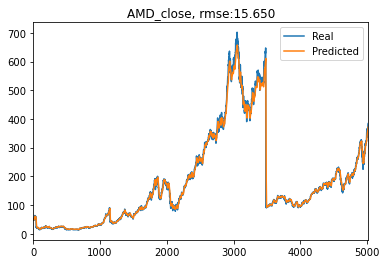

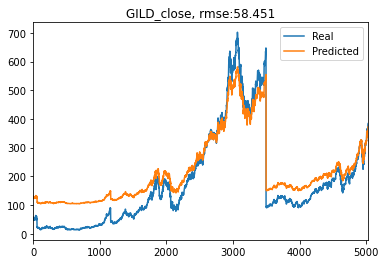

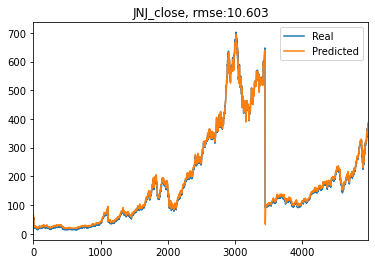

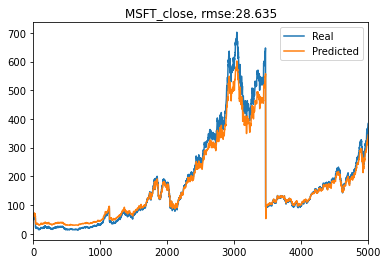

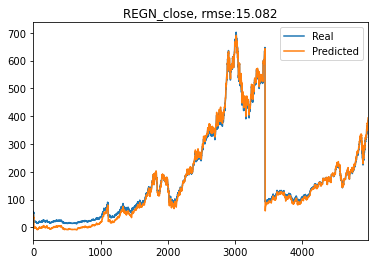

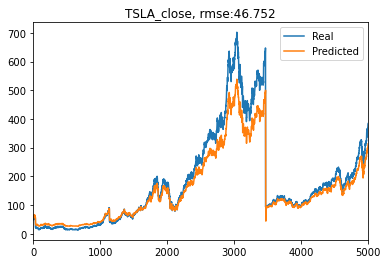

In [15]:
for index, row in df_candidates_1lstm.iterrows():
    csv_path = Path('./results/'+row['stock']+'_1lstm_model.csv')
    df_results = pd.read_csv(csv_path)
    df_results.drop(columns='Unnamed: 0', inplace=True)
    rmse = mean_squared_error(df_results.iloc[:,0],df_results.iloc[:,1], squared=False)
    df_results.plot(title=f'{row["stock"]}, rmse:{rmse:.3f}')

### 2 LSTM layers

In [73]:
# prepare AAPL data for model consumption, and predict prices using 2lstm models
# for index, row in df_candidates_2lstm.iterrows():
#     X_AAPL, y_AAPL = window_data(
#         df=AAPL_df,
#         window = row['window size'],
#         feature_col_number=0,
#         target_col_number=0
#     )
    
#     scaler = MinMaxScaler()
#     X = scaler.fit(X_AAPL)
#     X = scaler.transform(X_AAPL)
#     y = scaler.fit(y_AAPL)
#     y = scaler.transform(y_AAPL)
    
#     X = X.reshape((X.shape[0], X.shape[1], 1))

#     # Load json and create model
#     model_path = './models/'+row['stock']+'_2lstm_model.h5'
    
#     #load model
#     model = load_model(model_path)
    
#     # predict prices
#     predicted = model.predict(X)
    
#     # Recover the original prices instead of the scaled version
#     predicted_prices = scaler.inverse_transform(predicted)
#     real_prices = scaler.inverse_transform(y.reshape(-1, 1))
    
#     stocks = pd.DataFrame({
#     "Real": real_prices.ravel(),
#     "Predicted": predicted_prices.ravel()
#     })
    
#     stocks_path = Path('./results/'+row['stock']+'_2lstm_model.csv')
    
#     stocks.to_csv(stocks_path)

ValueError: Error when checking input: expected lstm_14_input to have shape (15, 1) but got array with shape (50, 1)

In [ ]:
for index, row in df_candidates_2lstm.iterrows():
    csv_path = Path('./results/'+row['stock']+'_2lstm_model.csv')
    df_results = pd.read_csv(csv_path)
    df_results.drop(columns='Unnamed: 0', inplace=True)
    rmse = mean_squared_error(df_results.iloc[:,0],df_results.iloc[:,1], squared=False)
    df_results.plot(title=f'{row["stock"]}, rmse:{rmse:.3f}')

***

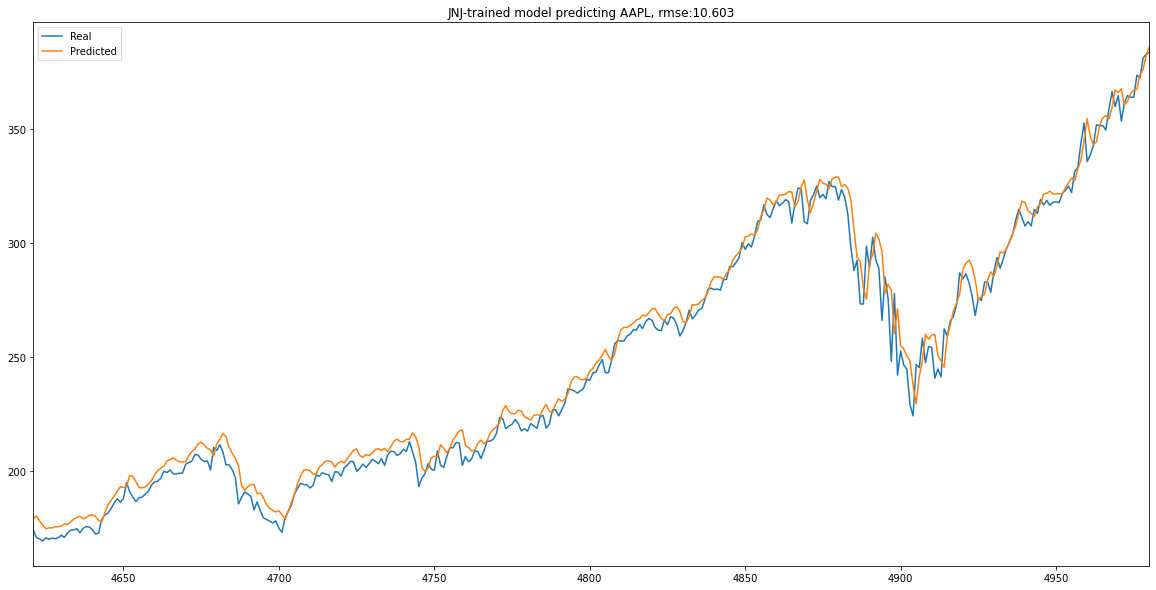

In [16]:
csv_path = Path('./results/JNJ_close_1lstm_model.csv')
df_jnj_1lstm_model = pd.read_csv(csv_path)
df_jnj_1lstm_model.drop(columns='Unnamed: 0', inplace=True)
rmse = mean_squared_error(df_jnj_1lstm_model.iloc[:,0],df_jnj_1lstm_model.iloc[:,1], squared=False)
df_jnj_1lstm_model.iloc[-360:,:].plot(figsize=(20,10), title=f'JNJ-trained model predicting AAPL, rmse:{rmse:.3f}')

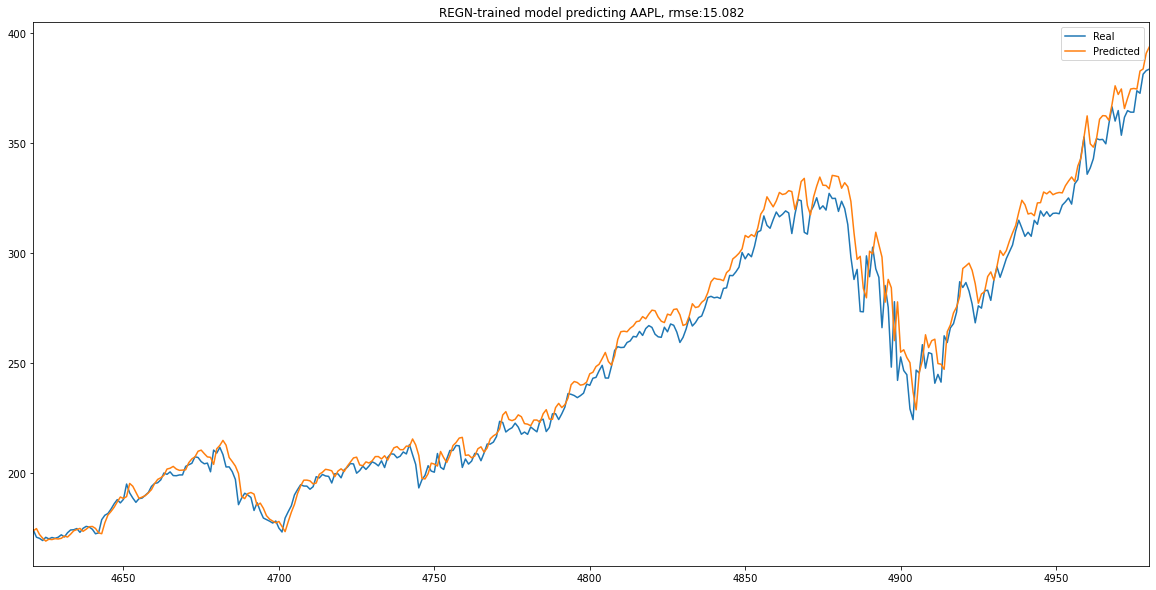

In [17]:
csv_path = Path('./results/REGN_close_1lstm_model.csv')
df_regn_1lstm_model = pd.read_csv(csv_path)
df_regn_1lstm_model.drop(columns='Unnamed: 0', inplace=True)
rmse = mean_squared_error(df_regn_1lstm_model.iloc[:,0],df_regn_1lstm_model.iloc[:,1], squared=False)
df_regn_1lstm_model.iloc[-360:,:].plot(figsize=(20,10),title=f'REGN-trained model predicting AAPL, rmse:{rmse:.3f}')

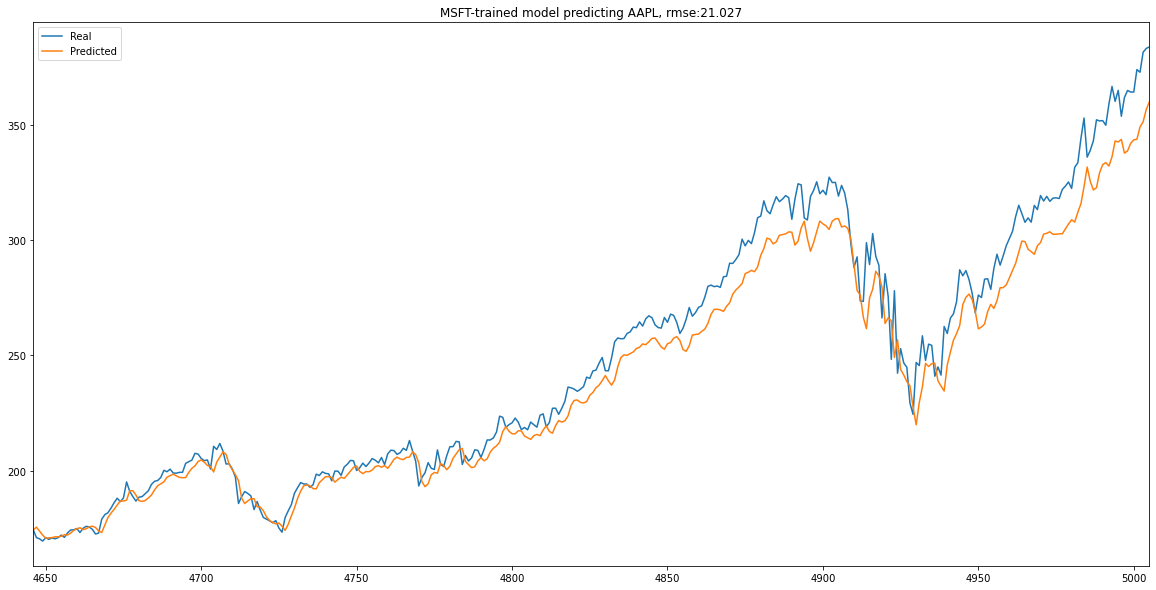

In [23]:
csv_path = Path('./results/AMD_close_1lstm_model.csv')
df_msft_1lstm_model = pd.read_csv(csv_path)
df_msft_1lstm_model.drop(columns='Unnamed: 0', inplace=True)
rmse = mean_squared_error(df_msft_1lstm_model.iloc[:,0],df_msft_1lstm_model.iloc[:,1], squared=False)
df_msft_1lstm_model.iloc[-360:,:].plot(figsize=(20,10), title=f'MSFT-trained model predicting AAPL, rmse:{rmse:.3f}')